<a href="https://colab.research.google.com/github/ilmondovero/sf/blob/main/PAC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

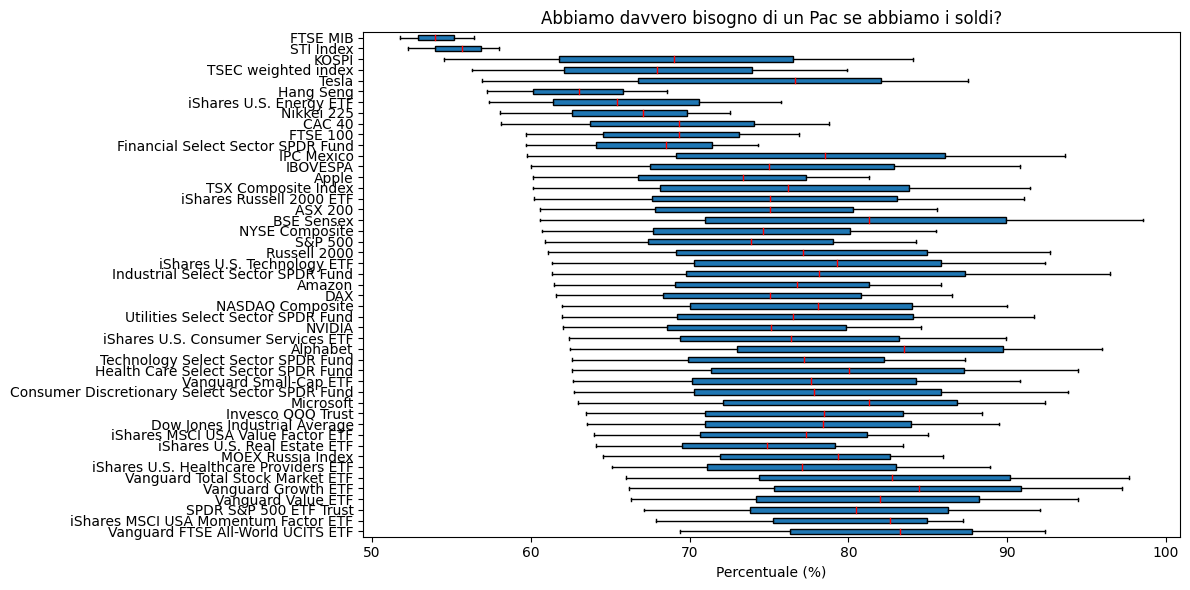

AttributeError: ignored

In [1]:
!pip install yfinance
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Mappatura dei nomi degli indici ai loro simboli Yahoo Finance
yahoo_indices = {
    "Vanguard FTSE All-World UCITS ETF": "VWCE.DE",
    "S&P 500": "^GSPC",
    "Dow Jones Industrial Average": "^DJI",
    "NASDAQ Composite": "^IXIC",
    "NYSE Composite": "^NYA",
    "Russell 2000": "^RUT",
    "Nikkei 225": "^N225",
    "FTSE 100": "^FTSE",
    "CAC 40": "^FCHI",
    "DAX": "^GDAXI",
    "Hang Seng": "^HSI",
    "BSE Sensex": "^BSESN",
    "ASX 200": "^AXJO",
    "IBOVESPA": "^BVSP",
    "IPC Mexico": "^MXX",
    "TSX Composite Index": "^GSPTSE",
    "KOSPI": "^KS11",
    "STI Index": "^STI",
    "TSEC weighted index": "^TWII",
    "MOEX Russia Index": "IMOEX.ME",
    "FTSE MIB": "FTSEMIB.MI",
    "Microsoft": "MSFT",
    "Apple": "AAPL",
    "Tesla": "TSLA",
    "Alphabet": "GOOGL",
    "NVIDIA": "NVDA",
    "Amazon": "AMZN",
    "SPDR S&P 500 ETF Trust": "SPY",
    "Invesco QQQ Trust": "QQQ",
    "Vanguard Total Stock Market ETF": "VTI",
    "iShares Russell 2000 ETF": "IWM",
    "iShares MSCI USA Value Factor ETF": "VLUE",
    "iShares MSCI USA Momentum Factor ETF": "MTUM",
    "Vanguard Growth ETF": "VUG",
    "Vanguard Value ETF": "VTV",
    "Vanguard Small-Cap ETF": "VB",
    "Technology Select Sector SPDR Fund": "XLK",
    "Financial Select Sector SPDR Fund": "XLF",
    "Health Care Select Sector SPDR Fund": "XLV",
    "Consumer Discretionary Select Sector SPDR Fund": "XLY",
    "Utilities Select Sector SPDR Fund": "XLU",
    "Industrial Select Sector SPDR Fund": "XLI",
    "iShares U.S. Real Estate ETF": "IYR",
    "iShares U.S. Consumer Services ETF": "IYC",
    "iShares U.S. Technology ETF": "IYW",
    "iShares U.S. Healthcare Providers ETF": "IHF",
    "iShares U.S. Energy ETF": "IYE"
}


# Definizione dei range di mesi per l'analisi
mesi_range = [3, 6, 12, 24, 36, 48, 60, 72, 84, 96, 120]

# Download dei dati di chiusura aggiustati per gli indici specificati
dati_indici = yf.download(tickers=list(yahoo_indices.values()), progress=False)["Adj Close"]

# Dizionari per archiviare i risultati
risultati, df_indici, diz_percentuali_vittoria= {}, {}, {}
statistiche= {"Percentuali Vittoria":0}
# Elaborazione per ciascun indice
for nome, simbolo in yahoo_indices.items():
    # Selezione e pulizia dei dati per l'indice corrente
    df_indice = dati_indici[simbolo].ffill().dropna().to_frame()
    date_indice = df_indice.index.values

    # Calcolo dei valori futuri per ciascun mese fino al massimo specificato
    for i in range(1, max(mesi_range)):
        date_target = df_indice.index + pd.DateOffset(months=i)
        posizioni = np.clip(np.searchsorted(date_indice, date_target), 0, len(df_indice) - 1)
        df_indice[i] = df_indice.iloc[posizioni][simbolo].values

    # Rinominazione della colonna principale per semplificazione
    df_indice.rename(columns={simbolo: 0}, inplace=True)

    # Creazione di un DataFrame per memorizzare i risultati
    df_risultati = pd.DataFrame(index=df_indice.index)
    df_percentuali_vittoria = pd.DataFrame(index=df_indice.index)
    # Calcolo delle performance e confronto tra PAC e PIC
    for r in mesi_range:
        colonne = range(r)
        #
        df_risultati[f"PAC{r}"] = (df_indice[colonne].rdiv(1).sum(axis=1) / r * df_indice[r - 1] - 1) * 100
        df_risultati[f"PIC{r}"] = (df_indice[r - 1] / df_indice[0] - 1) * 100
        df_percentuali_vittoria[f"PIC{r}"] = df_risultati[f"PIC{r}"] > df_risultati[f"PAC{r}"]

        # Aggiunta di statistiche descrittive per PAC e PIC
        statistiche.setdefault(nome, {})
        statistiche[nome][f"PAC{r}"] = df_risultati[f"PAC{r}"].describe(percentiles=[.1, .25, .5, .75, .9])
        statistiche[nome][f"PIC{r}"] = df_risultati[f"PIC{r}"].describe(percentiles=[.1, .25, .5, .75, .9])

        # Aggiunta di varianza e deviazione standard alle statistiche
        statistiche[nome][f"PAC{r}"]['var'] = df_risultati[f"PAC{r}"].var()
        statistiche[nome][f"PIC{r}"]['var'] = df_risultati[f"PIC{r}"].var()
        statistiche[nome][f"PAC{r}"]['std'] = df_risultati[f"PAC{r}"].std()
        statistiche[nome][f"PIC{r}"]['std'] = df_risultati[f"PIC{r}"].std()
        statistiche[nome][f"PIC{r}"]['%win'] = df_percentuali_vittoria[f"PIC{r}"].mean()*100
        statistiche[nome][f"PAC{r}"]['%win'] = 100-statistiche[nome][f"PIC{r}"]['%win']

    # Salvataggio dei risultati
    risultati[nome], df_indici[nome] = df_risultati.round(2), df_indice
    statistiche[nome] = pd.concat(statistiche[nome], axis=1).round(2)
    diz_percentuali_vittoria[nome]=df_percentuali_vittoria.mean().mul(100).round(2)

statistiche["Percentuali Vittoria"]= pd.concat(diz_percentuali_vittoria, axis=1).T
statistiche["Percentuali Vittoria"]["Min"]=statistiche["Percentuali Vittoria"].min(axis=1).round(2)
statistiche["Percentuali Vittoria"]["Max"]=statistiche["Percentuali Vittoria"].max(axis=1).round(2)
statistiche["Percentuali Vittoria"]["Media"]=statistiche["Percentuali Vittoria"].mean(axis=1).round(2)


#############################
######Creazione Grafico########
#############################

# Dati per il grafico a candele trasposto
data = statistiche["Percentuali Vittoria"][["Min", "Max", "Media"]]
data=data.sort_values(by="Min", ascending=False)
# Creazione del grafico boxplot modificato
fig, ax = plt.subplots(figsize=(12, 6))

# Creazione delle 'scatole' per il grafico
boxplot_data = [data.loc[indice, ["Min", "Media", "Max"]].values for indice in data.index]
ax.boxplot(boxplot_data, vert=False, patch_artist=True, showfliers=False, medianprops=dict(color="red"))

# Personalizzazione del grafico
ax.set_yticklabels(data.index)
ax.set_xlabel('Percentuale (%)')
ax.set_title('Abbiamo davvero bisogno di un Pac se abbiamo i soldi?')

plt.tight_layout()
plt.show()


#############################
######Creazione Excel########
#############################
# Funzione per auto-aggiustare la larghezza delle colonne
def auto_adjust_excel_columns(writer, df, sheet_name):
    for idx, width in enumerate(df.astype(str).applymap(len).max()):
        writer.sheets[sheet_name].set_column(idx, idx, width + 1)
    index_width = max(df.index.astype(str).map(len)) + 1
    writer.sheets[sheet_name].set_column(0, 0, index_width)

# [Elaborazione per ciascun indice]

# Creazione del foglio indice
indice_fogli = pd.DataFrame({'Link': [f"internal:'{name[:31]}'!A1" for name in statistiche.keys()]},
                            index=pd.Index(list(statistiche.keys()), name='Nome Foglio'))

with pd.ExcelWriter("Analisi_Indici_Finanziari.xlsx") as writer:
    # Scrittura e auto-aggiustamento del foglio indice
    indice_fogli.to_excel(writer, sheet_name="Indice")
    #auto_adjust_excel_columns(writer, indice_fogli, "Indice")

    for nome in statistiche:
        # Scrittura dei dati nel foglio Excel
        worksheet = writer.book.add_worksheet(nome[:31])
        statistiche[nome].sort_values(by=statistiche[nome].columns[-1]).to_excel(writer, sheet_name=nome[:31])
        worksheet.write_url('A1', "internal:Indice!A1")
        #auto_adjust_excel_columns(writer, statistiche[nome], nome[:31])
        # [Opzionale: Scrittura e auto-aggiustamento dei dati grezzi]
        # df_indici[nome].to_excel(writer, sheet_name=f'{nome[:25]}_Dati', startrow=1)
        # auto_adjust_excel_columns(writer, df_indici[nome], f'{nome[:25]}_Dati')
